<a href="https://colab.research.google.com/github/Lilly-yang/ELTE---Applied-Machine-Learning/blob/main/%E2%80%9CAssignment_2_Emotion_recognition_on_RAVDESS_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment 2/C
**Disclaimer: Only for ADL/AML students!**

### General information
**You have to solve all tasks to pass!**

Grade is calculated by the day of the last submission, but you will only get it after you've succesfully presented it. 

*Deadlines and grades:* 
  * 2020.10.27 - 2020.11.17 ==> 5
  * 2020.11.18 - 2020.11.24 ==> 4
  * 2020.11.25 - 2020.12.01 ==> 3
  * 2020.12.02 - 2020.12.08 ==> 2
  * 2020.12.09 or later ==> 1

You can **use only these** 3rd party **packages:** `cv2, keras, matplotlib, numpy, pandas, sklearn, skimage, tensorflow, librosa`.

### Description
In this assignment you have to build a multimodal deep neural network for emotion detection using tf.keras. You have to work with the RAVDESS dataset, which contains short (~4 seconds long) video clip recordings of speakers, who are acting the different emotions through 2 sentences. We will extract and combine RGB frames with MFCCs and utilize both video and audio information sources to achieve a better prediction.

### Use GPU
Runtime -> Change runtime type

At Hardware accelerator select  GPU then save it.  

### Useful shortcuts
* Run selected cell: *Ctrl + Enter*
* Insert cell below: *Ctrl + M B*
* Insert cell above: *Ctrl + M A*
* Convert to text: *Ctrl + M M*
* Split at cursor: *Ctrl + M -*
* Autocomplete: *Ctrl + Space* or *Tab*
* Move selected cells up: *Ctrl + M J*
* Move selected cells down: *Ctrl + M K*
* Delete selected cells: *Ctrl + M D*

If you have any question, feel free to ask.
fodorad201@gmail.com

## Mount Google Drive
Done the preprocessing steps offline and uploaded it to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare dataset

* Download the RAVDESS dataset. Here you can find more information about the dataset: https://zenodo.org/record/1188976#.X5g53OLPw2w
The dataset is available here as well: http://nipg1.inf.elte.hu:8765
ravdess.zip contains all of the mp4 clips. The labels are in the file names. (classification task)

* Preprocess the data.
  * Remove the silence parts from the beginning and the end of video clips. (Tips: ffmpeg filters)
  * Audio representation: 
    * Extract the audio from the video. (Tips: ffmpeg)
    * Extract 24 Mel Frequency Cepstral Coefficients from the audio. (Tips: use librosa.)
    * Calculate the mean number of (spectral) frames in the dataset.
    * Standardize the MFCCs sample-wise. (Tips: zero mean and unit variance)
    * Use pre-padding (Note: with 0, which is also the mean after standardization) to unify the length of the samples.
    * Audio representation per sample is a tensor with shape (N,M,1) where N is the number of coefficients (e.g. 24) and M is the number of audio frames.
  * Visual representation:
    * Extract the faces from the images. (Tips: You can use the cv2.CascadeClassifier, or the DLIB package to determine facial keypoints, or MTCNN to predict bounding boxes.)
    * Resize the face images to 64x64. (Tips: You can use lower/higher resolution as well.)
    * Subsample the frames to reduce complexity (6 frames/video is enough).
    * Apply data augmentation, and scaling [0, 1].
    * Video representation per sample is a tensor with shape (F,H,W,3) where F is the number of frames (e.g. 6), H and W are the spatial dimensions (e.g. 64).
  * Ground truth labels:
    * There are 8 class labels. However, Class 1 (Neutral) and Class 2 (Calm) are almost the same. It is a commonly used practice to merge these two classes. Combine them to reduce complexity.
    * (Optional) Use one-hot-encoding with categorical_crossentropy loss later on, or keep them between [0, 6] and use sparse_categorical_crossentropy loss. It's up to you.

* Split the datasets into train-valid-test sets. Samples from the same speaker shouldn't appear in multiple sets. (Example split using speaker ids: 1-17: train set, 18-22: validation set, 23-24: test set)
* Create a generator, which iterates over the audio and visual representations. (Note: the generator should produce a tuple ([x0, x1], y), where x0 is the audio, x1 is the video representation, y is the ground truth.
* Print the size of each set, plot 3 samples: frames, MFCCs and their corresponding emotion class labels. (Tips: use librosa for plotting MFCCs)

Alternative considerations. They may require additional steps:
* You can use Mean (axis=1) MFCCs vectors to further reduce complexity. Input of the corresponding subnetwork should be modified to accept inputs with shape (N, 1).
* You can use log-melspectrograms as well. Note, that raw spectrograms are displaying power. Mel scale should be applied on the frequency axis, and log on the third dimension (decibels are expected). You can use librosa for that (librosa.feature.melspectrogram, librosa.power_to_db)
* A better evaluation procedure here is the LOO (Leave-One-Out) cross-validation, however it can be costy.

### Download the RAVDESS dataset

In [ ]:
!wget -nc -O ravdess.zip http://nipg1.inf.elte.hu:8765/ravdess.zip

--2020-11-06 23:08:42--  http://nipg1.inf.elte.hu:8765/ravdess.zip
Resolving nipg1.inf.elte.hu (nipg1.inf.elte.hu)... 157.181.160.161
Connecting to nipg1.inf.elte.hu (nipg1.inf.elte.hu)|157.181.160.161|:8765... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565818088 (13G) [application/zip]
Saving to: ‘ravdess.zip’

ravdess.zip         100%[===================>]  12.63G  28.8MB/s    in 7m 33s  

2020-11-06 23:16:15 (28.6 MB/s) - ‘ravdess.zip’ saved [13565818088/13565818088]



In [ ]:
!unzip ravdess.zip

Archive:  ravdess.zip
   creating: ravdess/
 extracting: ravdess/Video_Speech_Actor_23.zip  
 extracting: ravdess/Video_Speech_Actor_09.zip  
 extracting: ravdess/Video_Speech_Actor_12.zip  
 extracting: ravdess/Video_Speech_Actor_05.zip  
 extracting: ravdess/Audio_Speech_Actors_01-24.zip  
 extracting: ravdess/Video_Speech_Actor_22.zip  
 extracting: ravdess/Video_Speech_Actor_06.zip  
 extracting: ravdess/Video_Speech_Actor_04.zip  
 extracting: ravdess/Video_Speech_Actor_01.zip  
 extracting: ravdess/Video_Speech_Actor_16.zip  
 extracting: ravdess/Video_Speech_Actor_17.zip  
 extracting: ravdess/Video_Speech_Actor_21.zip  
 extracting: ravdess/Video_Speech_Actor_03.zip  
 extracting: ravdess/Video_Speech_Actor_20.zip  
 extracting: ravdess/Video_Speech_Actor_07.zip  
 extracting: ravdess/Video_Speech_Actor_02.zip  
 extracting: ravdess/Video_Speech_Actor_14.zip  
 extracting: ravdess/Video_Speech_Actor_10.zip  
 extracting: ravdess/Video_Speech_Actor_08.zip  
 extracting: ravdess/

### Preprocess the data

#### Import liborary

In [ ]:
pip install keras_vggface

In [ ]:
pip install keras_applications

     |████████████████████████████████| 51kB 4.3MB/s 


In [ ]:
%matplotlib inline

import os
import pickle
import librosa.display
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from keras_vggface.vggface import VGGFace
from keras.engine import Model
from keras.layers import Flatten, Dense, Input
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import math
import numpy as np
from sklearn.model_selection import LeaveOneOut, KFold
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

#### Ground truth labels

In [ ]:
def get_lable(y):
    lable = int(y)
    # merge 1-nature and 2-calm classes
    if lable == 1:
        lable += 1

    # Use one-hot-encoding with categorical_crossentropy loss
    lable = tf.keras.utils.to_categorical(lable - 2, 7)

    return lable

### Split the datasets into train-valid-test sets
- Print the size of each set

In [ ]:
def path_generator(path_path, split_range):
    path_list = []
    for i in split_range:
        actor_path = os.path.join(RADVESS_PATH, actors[i])
        path_list += [os.path.join(actor_path, j) for j in os.listdir(actor_path)]

    return path_list


RADVESS_PATH = '/content/drive/MyDrive/ELTE/AML/RAVDESS'
actors = os.listdir(RADVESS_PATH)
actors.sort()

train_set = [i for i in range(24)]
valid_set = [7, 10]  # [3,7,10,13,23]
test_set = [1, 15]  # [5,15]
train_set = list(set(train_set) - set(valid_set) - set(test_set))

train_paths = path_generator(RADVESS_PATH, train_set)
valid_paths = path_generator(RADVESS_PATH, valid_set)
test_paths = path_generator(RADVESS_PATH, test_set)

print('train_paths: %d' % len(train_paths))
print('train_paths: %d' % len(valid_paths))
print('train_paths: %d' % len(test_paths))

train_paths: 1200
train_paths: 120
train_paths: 120


### Create a generator
 The generator should produce a tuple ([x0, x1], y), where x0 is the audio, x1 is the video representation, y is the ground truth.

In [ ]:
def read_pkl(pkl_path):
    infile = open(pkl_path, 'rb')
    new_dict = pickle.load(infile)
    infile.close()

    return new_dict


batch_size = 115


def myGenerator(data_path, batch_size=60, shuffle=True):
    x_a = []
    x_v = []
    y = []
    if shuffle:
        for i in range(3):
            random.shuffle(data_path)
    for i in data_path:
        audio = read_pkl(os.path.join(i, 'mfcc_sample.pkl'))
        audio = tf.squeeze(audio)
        image = read_pkl(os.path.join(i, 'face_sample.pkl'))

        x_a.append(audio)
        x_v.append(image)
        y.append(get_lable(i.split('-')[-5]))

    total_size = len(data_path)

    while True:
        for i in range(total_size // batch_size):
            yield [tf.stack(x_a[i * batch_size:(i + 1) * batch_size]),
                   tf.stack(x_v[i * batch_size:(i + 1) * batch_size])], tf.stack(y[i * batch_size:(i + 1) * batch_size])

### Plot 3 samples
frames, MFCCs and their corresponding emotion class labels.

In [ ]:
x, y = next(myGenerator(train_paths, batch_size))

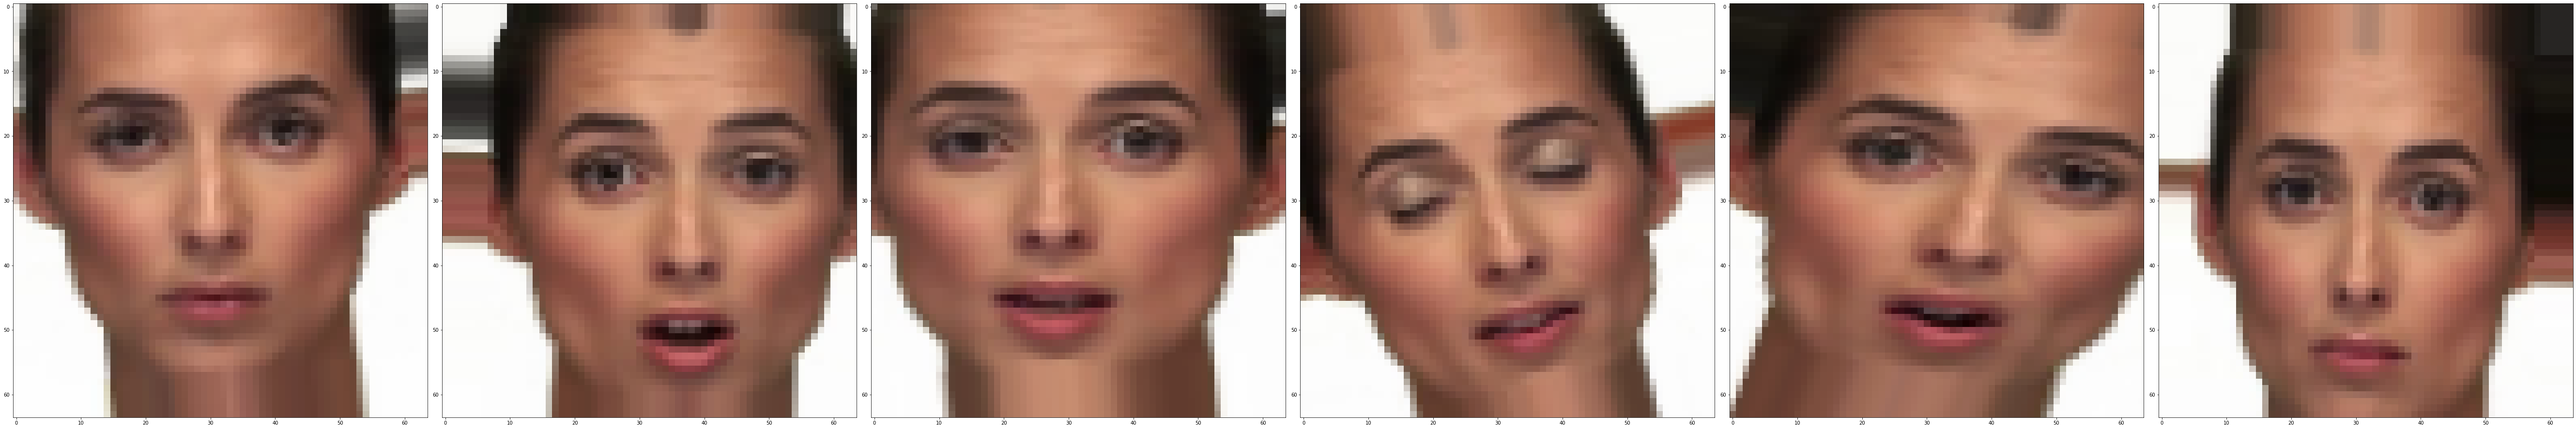

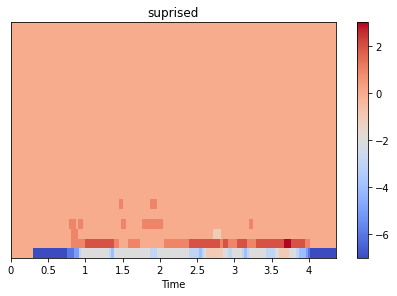

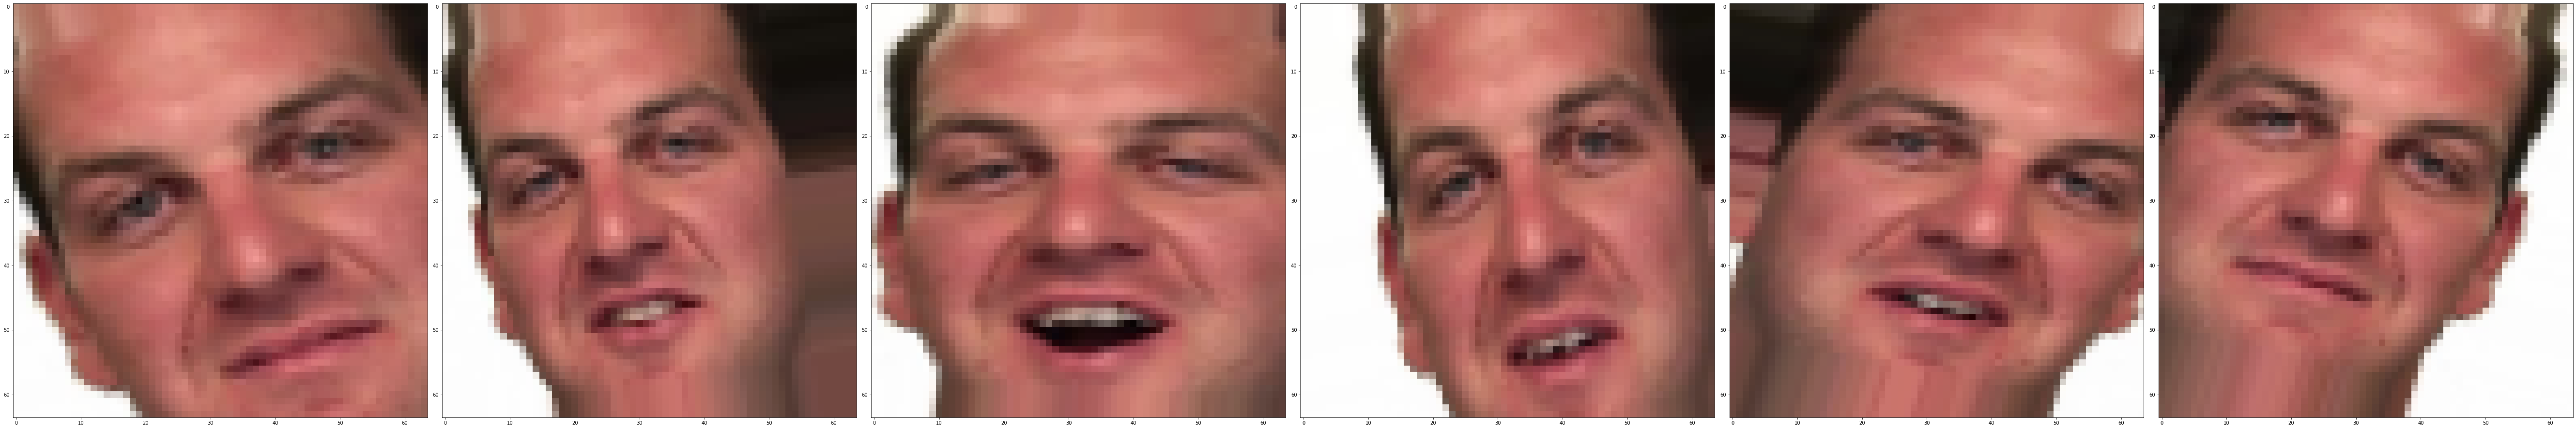

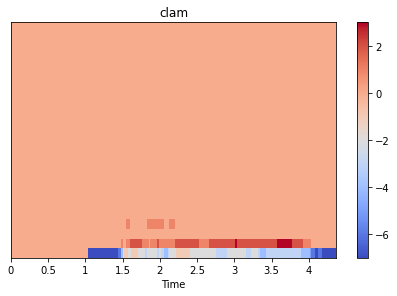

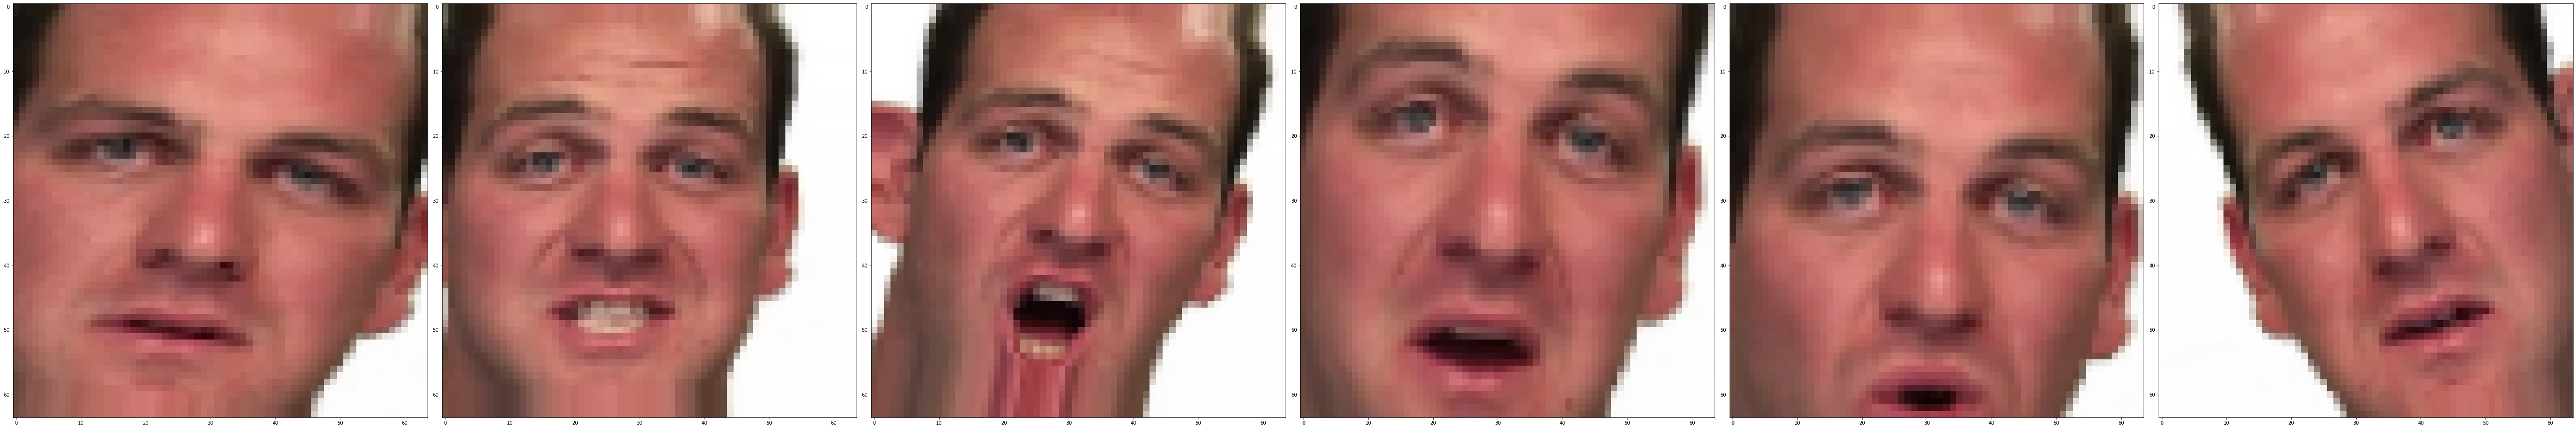

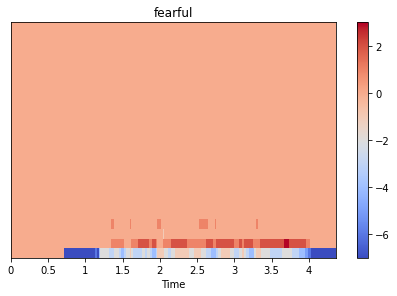

In [ ]:
def plot_mfcc(mfccs, title):
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.tight_layout()
    plt.title(title)
    plt.show()


emotion = ['clam', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'suprised']
audio = x[0]
image = x[1]

for i in range(3):
    plt.figure(figsize=(74, 370))
    for j in range(6):
        plt.subplot(1, 6, j + 1)
        plt.imshow(image[i][j])
    plt.tight_layout()
    plt.show()

    plot_mfcc(audio[i].numpy().squeeze(), emotion[np.where(y[i] == 1)[0][0]])

## Create Model

* Create the audio subnetwork
  * Choose one of these:
    * BLSTM (64 units, return sequences) + Dropout 0.5 + BLSTM (64 units) + Dense (128 units, ReLU)
    * Conv1D (32 filters, 3x3) + BatchNorm + ReLU, Conv1D (32 filters, 3x3) + BatchNorm + ReLU, Conv1D (64 filters, 3x3) + BatchNorm + ReLU, LSTM (64 units) + Dropout 0.5 + Dense (128 units, ReLU)
    * Conv2D (32 filters, 3x3) + BatchNorm + ReLU, MaxPool2D, Conv2D (32 filters, 3x3) + BatchNorm + ReLU, MaxPool2D, Flatten, Dense (128 units, ReLU)
  * You can try other configurations, better submodels. Have a reason for your choice!
* Create the visual subnetwork
  * Choose a visual backbone, which is applied frame-wise (Tips: use TimeDistributed Layer for this):
    * VGG-like architecture (Conv2D + MaxPooling blocks)
    * ResNet / Inception architecture (Residual blocks, Inception cells)
  * You can try other configurations, better submodels (like 3D convolution nets). Have a reason for your choice!
  * Apply Max pooling over the time dimension to reduce complexity (or use GRU or LSTM for better temporal modelling)
* Model fusion:
  * Concatenate the final hidden representations of the audio and visual subnetwork.
  * Apply fully connected layers on it (256 units, ReLU), then an another dense layer (7 units, softmax).
  * You can feed multiple inputs to the Model using a list: 
  model = tf.keras.models.Model(inputs=[input_audio, input_video], outputs=output)

## Extra task (Optional)
Use the VGGFace2 model (and pretrained weights) in the visual subnetwork. It is trained on faces, so a much better representation can be obtained with it. Finetune the network for enhanced prediction.
(code: https://github.com/rcmalli/keras-vggface, but other implementation can be used as well)
Note, that this repository use the classic keras, while we are using tf.keras.
It may rise compatibility problems.

**If you can successfully use the VGGFace2 pretrained net, +1 is added to the final grade.**

### Parameters

In [ ]:
l1 = 5e-4
l2 = 5e-4
kernel_regularizer = regularizers.l2(1e-3)
dropout = .3

### Create the audio subnetwork


#### Audio Model 1
Bidirectional Long Short-Term Memory(BLSTM, 64 units, return sequences) + Dropout 0.5 + BLSTM (64 units) + Dense (128 units, ReLU)

In [ ]:
def getAModel1():
    a_model = Sequential()
    a_model.add(Input(shape=(24, 188)))
    a_model.add(Bidirectional(LSTM(64, dropout=.5, return_sequences=True, kernel_regularizer=kernel_regularizer)))
    a_model.add(Bidirectional(LSTM(64, dropout=.5, kernel_regularizer=kernel_regularizer)))
    a_model.add(Dropout(.3))
    a_model.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer))
    a_model.add(Dropout(.2))

    return a_model


a_model = getAModel1()
a_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 24, 128)           129536    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
Total params: 244,864
Trainable params: 244,864
Non-trainable params: 0
_________________________________________________________________


#### Audio Model 2
Conv1D (32 filters, 3x3) + BatchNorm + ReLU, Conv1D (32 filters, 3x3) + BatchNorm + ReLU, Conv1D (64 filters, 3x3) + BatchNorm + ReLU, LSTM (64 units) + Dropout 0.5 + Dense (128 units, ReLU)

In [ ]:
def getAModel2():
    a_model = Sequential()

    a_model.add(Input(shape=(24, 188)))

    a_model.add(Conv1D(32, 3, activation='relu'))
    a_model.add(BatchNormalization())

    a_model.add(Conv1D(32, 3, activation='relu'))
    a_model.add(BatchNormalization())

    a_model.add(Conv1D(64, 3, activation='relu'))
    a_model.add(BatchNormalization())

    a_model.add(LSTM(64, dropout=.5))
    a_model.add(Dense(128, activation='relu'))

    return a_model


a_model = getAModel2()
a_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_12 (Dropout)         (None, 24, 188)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 32)            18080     
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 32)            128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 22, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 32)            3104      
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 32)            128       
_________________________________________________________________
dropout_14 (Dropout)         (None, 20, 32)           

#### Audio Model 3
Conv2D (32 filters, 3x3) + BatchNorm + ReLU, MaxPool2D, Conv2D (32 filters, 3x3) + BatchNorm + ReLU, MaxPool2D, Flatten, Dense (128 units, ReLU)

In [ ]:
def getAModel3():
    a_model = Sequential()

    a_model.add(Input(shape=(24, 188, 1)))

    a_model.add(Conv2D(32, 3, activation='relu'))
    a_model.add(BatchNormalization())
    a_model.add(MaxPool2D())

    a_model.add(Conv2D(32, 3, activation='relu'))
    a_model.add(BatchNormalization())
    a_model.add(MaxPool2D())

    a_model.add(Flatten())
    a_model.add(Dense(128, activation='relu'))

    return a_model


a_model = getAModel3()
a_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_17 (Dropout)         (None, 24, 188, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 186, 32)       320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 22, 186, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 93, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 11, 93, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 91, 32)         9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 9, 91, 32)        

### Create the visual subnetwork

#### VGG-VGGFace2 architecture
- Code: https://github.com/rcmalli/keras-vggface
- Apply Max pooling over the time dimension to reduce complexity (or use GRU or LSTM for better temporal modelling)

In [ ]:
# create a VGG-like "model"
def getVGGLikeModel():
    nb_class = 7
    # vgg_model = VGG19(include_top=False, weights=None, input_shape=(64, 64, 3), classes=nb_class)
    vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3), classes=nb_class)

    for layer in vgg_model.layers[:9]:
        layer.trainable = False

    # vgg_model.summary()

    last_layer = vgg_model.get_layer('pool3').output
    # x = Flatten(name='flatten')(last_layer)
    # x = Dense(256, activation='relu', name='fc6')(x)
    # x = Dense(256, activation='relu', name='fc7')(x)
    # out = Dense(nb_class, activation='softmax', name='fc8')(x)
    custom_vgg_model = Model(vgg_model.input, last_layer)

    # custom_vgg_model.summary()

    v_model = Sequential()
    v_model.add(TimeDistributed(custom_vgg_model, input_shape=(6, 64, 64, 3)))
    v_model.add(TimeDistributed(Flatten()))

    # 1.maxpooling
    # v_model.add(MaxPooling1D())
    # v_model.add(Flatten())

    # 3.RGU
    v_model.add(GRU(64, activation='relu', kernel_initializer='he_normal', dropout=.5,
                    kernel_regularizer=kernel_regularizer))

    # 2.LSTM
    # v_model.add(LSTM(64, activation='relu', kernel_initializer='he_normal', dropout=.5,
    #                  kernel_regularizer=kernel_regularizer))

    v_model.add(Dropout(.3))
    v_model.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer))
    v_model.add(Dropout(.2))

    return v_model


v_model = getVGGLikeModel()
v_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 6, 8, 8, 256)      1735488   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 6, 16384)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                4210944   
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
Total params: 5,954,752
Trainable params: 4,809,344
Non-trainable params: 1,145,408
___________________________________

### Model fusion
- Concatenate the final hidden representations of the audio and visual subnetwork.
- Apply fully connected layers on it (256 units, ReLU), then an another dense layer (7 units, softmax).
- Feed multiple inputs to the Model using a list: model = tf.keras.models.Model(inputs=[input_audio, input_video], outputs=output)

In [ ]:
def getModel(a_model, v_model, param=1e-3):
    input = [a_model.input, v_model.input]

    x = Concatenate()([a_model.output, v_model.output])
    x = Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer)(x)
    output = Dense(7, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input, outputs=output)

    return model


multi_model = getModel(a_model, v_model)
multi_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 24, 188, 1)] 0                                            
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 24, 188, 1)   0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 22, 186, 32)  320         dropout_17[0][0]                 
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 22, 186, 32)  128         conv2d_1[0][0]                   
_______________________________________________________________________________________

## Additional notes

* Do the preprocessing steps offline, create pkl (or npy, hdf5, etc..) files, so you don't have to repeat most of the steps again. Then you can upload it, and train using colab without much struggling.
* Use Adam optimizer.
* Use learning rate scheduler.
* Check the training curve. If overfitting happens, add more regularization: weight decay (L2: 1e-3, 5e-4, etc...), Dropout

### Use Adam optimizer & learning rate scheduler

In [ ]:
def modelCompile(model, metrics='accuracy', lr=1e-3):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                                 decay_steps=10000,
                                                                 decay_rate=0.9)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[metrics])

    return model

### Training
Check the training curve. If overfitting happens, add more regularization: weight decay (L2: 1e-3, 5e-4, etc...), Dropout

In [ ]:
def getCallbacks(early_stop=None, patience=0, model_check=None, mode=None, che_poi_name='best_model'):
    callbacks = []
    if early_stop:
        callbacks.append(EarlyStopping(monitor=early_stop, mode='min', verbose=1,
                                       patience=patience))

    if model_check:
        filepath = os.path.join('/content/drive/MyDrive/ELTE/AML', che_poi_name + '.h5')
        callbacks.append(ModelCheckpoint(filepath, monitor=model_check, mode=mode,
                                         verbose=1, save_best_only=True))

    return callbacks

#### Normal Traning

In [ ]:
K.clear_session()
tf.compat.v1.reset_default_graph()

train_batch_size = 300
valid_batch_size = 120
test_batch_size = 120
ephoch = 150

train_generator = myGenerator(train_paths, train_batch_size)
valid_generator = myGenerator(valid_paths, valid_batch_size)
test_generator = myGenerator(test_paths, test_batch_size)

# define model
a_model = getAModel1()  # getAModel1, getAModel2, getAModel3
v_model = getVGGLikeModel()
model = getModel(a_model, v_model)
model = modelCompile(model, lr=5e-4)

# fit model
H = model.fit(train_generator, epochs=ephoch, steps_per_epoch=len(train_paths) / train_batch_size,
              validation_data=valid_generator, validation_steps=len(valid_paths) / valid_batch_size,
              callbacks=getCallbacks(early_stop='loss', patience=5, model_check='val_accuracy', mode='max'))

Epoch 1/150
4/4 [==============================] - ETA: 0s - loss: 49.0929 - accuracy: 0.1408
Epoch 00001: val_accuracy improved from -inf to 0.16667, saving model to /content/drive/MyDrive/ELTE/AML/best_model.h5
4/4 [==============================] - 4s 931ms/step - loss: 49.0929 - accuracy: 0.1408 - val_loss: 4.2165 - val_accuracy: 0.1667
Epoch 2/150
4/4 [==============================] - ETA: 0s - loss: 5.1000 - accuracy: 0.1358
Epoch 00002: val_accuracy did not improve from 0.16667
4/4 [==============================] - 2s 443ms/step - loss: 5.1000 - accuracy: 0.1358 - val_loss: 4.0753 - val_accuracy: 0.1333
Epoch 3/150
4/4 [==============================] - ETA: 0s - loss: 4.0675 - accuracy: 0.1433
Epoch 00003: val_accuracy did not improve from 0.16667
4/4 [==============================] - 2s 449ms/step - loss: 4.0675 - accuracy: 0.1433 - val_loss: 4.0457 - val_accuracy: 0.1417
Epoch 4/150
4/4 [==============================] - ETA: 0s - loss: 4.0370 - accuracy: 0.1533
Epoch 0000

#### LOO (Leave-One-Out) cross-validation

In [ ]:
loo = LeaveOneOut()

train_batch_size = 115
test_batch_size = 60
ephoch = 100

all_train, all_test, all_H = list(), list(), list()
for train_index, test_index in loo.split(np.array(actors)):
    print("TRAIN:", train_index, "Test:", test_index)
    train_paths = path_generator(RADVESS_PATH, train_index)
    test_paths = path_generator(RADVESS_PATH, test_index)

    train_generator = myGenerator(train_paths, train_batch_size)
    test_generator = myGenerator(test_paths, test_batch_size)

    # define model
    a_model = getAModel1()  # getAModel1, getAModel2, getAModel3
    v_model = getVGGLikeModel()
    model = getModel(a_model, v_model)
    model = modelCompile(model, 'acc', lr=1e-3)

    # fit model
    model.fit(train_generator, epochs=ephoch, steps_per_epoch=len(train_paths) / train_batch_size,
              callbacks=getCallbacks(early_stop='loss', patience=5, model_check='acc', mode='max'))

    # evaluate the model
    model = tf.keras.models.load_model('/content/drive/MyDrive/ELTE/AML/best_model.h5')
    _, train_acc = model.evaluate(train_generator, batch_size=train_batch_size,
                                  steps=len(train_paths) / train_batch_size,
                                  verbose=0)
    _, test_acc = model.evaluate(test_generator, batch_size=test_batch_size, steps=len(test_paths) / test_batch_size,
                                 verbose=0)
    print('Validation set: %s, Train: %.3f, Test: %.3f' % (actors[test_index[0]], train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)
    print('Ave-Train: %.3f, Test: %.3f' % (sum(all_train) / len(all_train), sum(all_test) / len(all_test)))

    K.clear_session()
    tf.compat.v1.reset_default_graph()

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] Test: [0]
Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 22.2188 - acc: 0.1471
Epoch 00001: acc improved from -inf to 0.14710, saving model to /content/drive/MyDrive/ELTE/AML/best_model.h5
12/12 [==============================] - 3s 216ms/step - loss: 22.2188 - acc: 0.1471
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 2.0584 - acc: 0.1957
Epoch 00002: acc improved from 0.14710 to 0.19565, saving model to /content/drive/MyDrive/ELTE/AML/best_model.h5
12/12 [==============================] - 2s 207ms/step - loss: 2.0584 - acc: 0.1957
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 2.0088 - acc: 0.2297
Epoch 00003: acc improved from 0.19565 to 0.22971, saving model to /content/drive/MyDrive/ELTE/AML/best_model.h5
12/12 [==============================] - 3s 210ms/step - loss: 2.0088 - acc: 0.2297
Epoch 4/100
12/12 [==============================] -

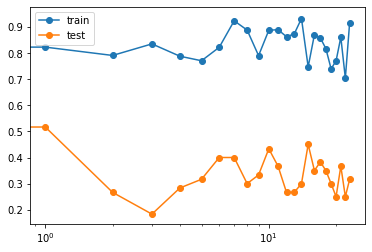

In [ ]:
# plot train and test means
plt.semilogx(all_train, label='train', marker='o')
plt.semilogx(all_test, label='test', marker='o')
plt.legend()

## Final steps - evaluation

* Plot the training / validation curve.
* Calculate accuracy, print a confusion matrix.

### Plot the traning / validation curve

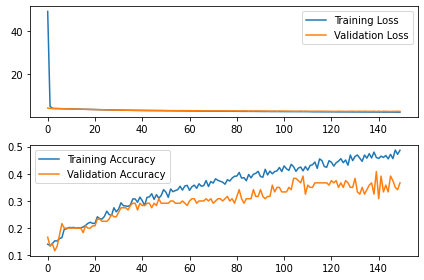

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(H.history["loss"], label="Training Loss")
plt.plot(H.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(H.history["accuracy"], label="Training Accuracy")
plt.plot(H.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()

### Calculate test accuracy and print a confusion matrix

Test accuracy is: 0.542


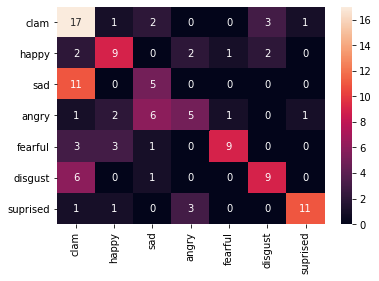

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ELTE/AML/best_model.h5')
_, test_acc = model.evaluate(test_generator, batch_size=test_batch_size, steps=len(test_paths) / test_batch_size,
                             verbose=0)
print('Test accuracy is: %.3f' % (test_acc))

X_test, y_test = next(test_generator)
y_predict = model.predict(X_test)

y_pred, y_true = [], []
for ind, y in enumerate(y_predict):
    y_pred.append(np.where(y == np.max(y))[0][0])
    temp_y_true = y_test[ind].numpy()
    y_true.append(np.where(temp_y_true == np.max(temp_y_true))[0][0])

array = confusion_matrix(y_true, y_pred)

emotion = ['clam', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'suprised']
df_cm = pd.DataFrame(array, index=[i for i in emotion],
                     columns=[i for i in emotion])
plt.figure()
sn.heatmap(df_cm, annot=True)